In [1]:
import numpy as np

from sklearn.linear_model import LinearRegression as LinR, Lasso as LasR
import matplotlib.pyplot as plt
%matplotlib inline

In [446]:
rng = np.random.RandomState(20170808)
n_data = 50
alpha = .01

X_cov = np.array([[1., 0., 0.],
                  [0., .6, .599],
                  [0., .599, .6]])
M = np.array([-.5, .5, .05])
noise_std = .5

In [447]:
X = rng.multivariate_normal(np.zeros_like(M), X_cov, n_data)
X /= X.std(axis=0, keepdims=True)

In [448]:
Y = X.dot(M) + rng.randn(n_data) * noise_std

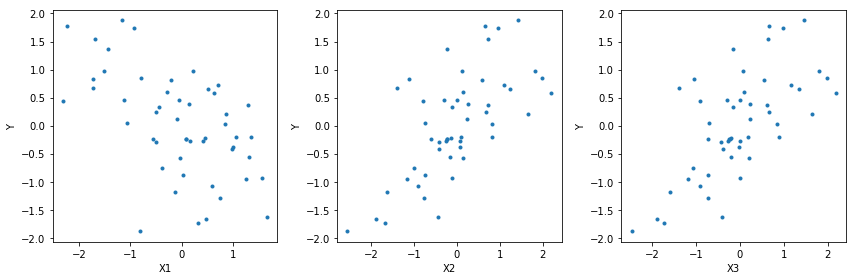

In [449]:
f, axes = plt.subplots(1, 3, figsize=(12, 4))
for ii, ax in enumerate(axes):
    ax.plot(X[:, ii], Y, '.')
    ax.set_ylabel('Y')
    ax.set_xlabel('X{}'.format(ii+1))
f.tight_layout()
plt.show()

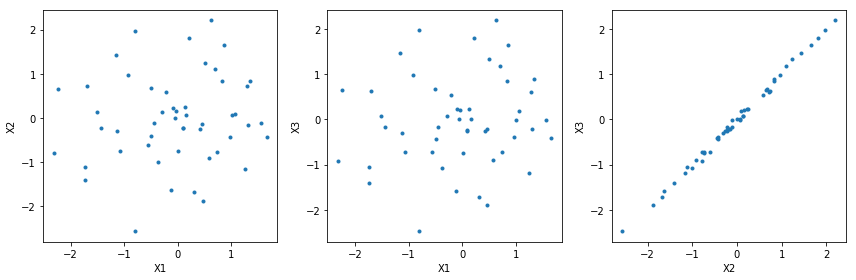

In [450]:
f, axes = plt.subplots(1, 3, figsize=(12, 4))
idx = 0
for ii in range(3):
    for jj in range(ii+1, 3):
        axes[idx].plot(X[:, ii], X[:, jj], '.')
        axes[idx].set_ylabel('X{}'.format(jj+1))
        axes[idx].set_xlabel('X{}'.format(ii+1))
        idx += 1
f.tight_layout()
plt.show()

In [451]:
def fit_linear(X, Y):
    return LinR(fit_intercept=False).fit(X, Y).coef_

def fit_lasso(X, Y, alpha):
    return LasR(alpha=.1, fit_intercept=False).fit(X, Y).coef_

def fit_lasso_linear(X, Y, alpha):
    las = fit_lasso(X, Y, alpha)
    if np.count_nonzero(las) < X.shape[1]:
        result = np.zeros_like(las)
        nz = np.nonzero(las)[0]
        Xp = X[:, nz]
        lin = fit_linear(Xp, Y)
        result[nz] = lin
        return result
    else:
        return las

In [452]:
lin_est = fit_linear(X, Y)
las_est = fit_lasso(X, Y, alpha)
laslin_est = fit_lasso_linear(X, Y, alpha)

In [453]:
def lin_cost(X, Y, M):
    n = M.shape[0]
    cost = np.zeros(n)
    for ii, Mi in enumerate(M):
        cost[ii] = np.mean((Y - X.dot(Mi))**2)
    return cost

def abs_cost(M, alpha):
    n = M.shape[0]
    cost = np.zeros(n)
    for ii, Mi in enumerate(M):
        cost[ii] = alpha * np.sum(abs(Mi))
    return cost

def las_cost(X, Y, M, alpha):
    return lin_cost(X, Y, M) + abs_cost(M, alpha)

In [454]:
n_pts = 100
limit = 1
locs = np.linspace(-limit, limit, n_pts)
M_grid = np.stack([a.ravel() for a in np.meshgrid(locs,
                                                  locs)]).T
M_grid = np.concatenate((M[0] * np.ones((n_pts**2, 1)), M_grid), axis=1)

In [455]:
lin_c = lin_cost(X, Y, M_grid).reshape(n_pts, n_pts)
abs_c = abs_cost(M_grid, alpha).reshape(n_pts, n_pts)
las_c = las_cost(X, Y, M_grid, alpha).reshape(n_pts, n_pts)

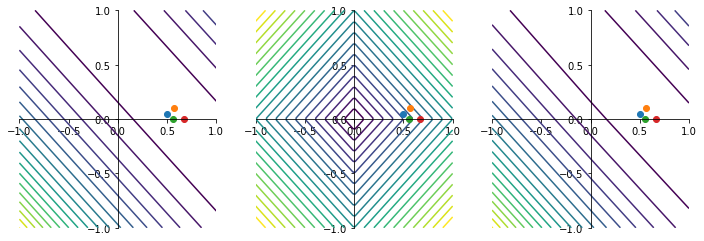

In [456]:
f, axes = plt.subplots(1, 3, figsize=(12, 4))

X_locs = M_grid.T[1].reshape(n_pts, n_pts)
Y_locs = M_grid.T[2].reshape(n_pts, n_pts)

for ax, data in zip(axes, [lin_c, abs_c, las_c]):
    ax.contour(X_locs, Y_locs, data, 20)
    ax.plot(M[1], M[2], 'o')
    ax.plot(lin_est[1], lin_est[2], 'o')
    ax.plot(las_est[1], las_est[2], 'o')
    ax.plot(laslin_est[1], laslin_est[2], 'o')
    ax.set_xticks(np.linspace(-1, 1, 5))
    ax.set_yticks(np.linspace(-1, 1, 5))

    # Move left y-axis and bottim x-axis to centre, passing through (0,0)
    ax.spines['left'].set_position(('data', 0))
    ax.spines['bottom'].set_position(('data', 0))

    # Eliminate upper and right axes
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')

    # Show ticks in the left and lower axes only
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')

In [457]:
n_trials = 10000
lin_m = np.zeros((n_trials, 2))
las_m = np.zeros((n_trials, 2))
laslin_m = np.zeros((n_trials, 2))
for ii in range(n_trials):
    X = rng.multivariate_normal(np.zeros_like(M), X_cov, n_data)
    X /= X.std(axis=0, keepdims=True)
    Y = X.dot(M) + rng.randn(n_data) * noise_std
    lin_m[ii] = fit_linear(X, Y)[1:]
    las_m[ii] = fit_lasso(X, Y, alpha)[1:]
    laslin_m[ii] = fit_lasso_linear(X, Y, alpha)[1:]

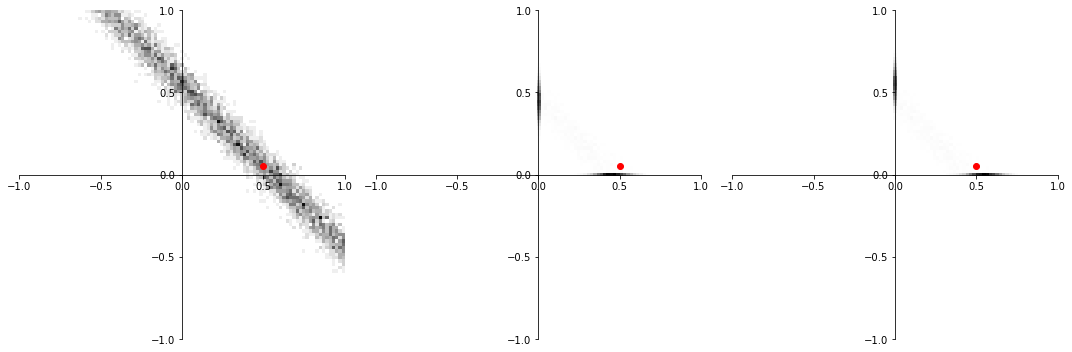

In [458]:
f, axes = plt.subplots(1, 3, figsize=(15, 5))

for ax, data in zip(axes, [lin_m, las_m, laslin_m]):
    ax.hist2d(data[:,0], data[:,1], bins=np.linspace(-1, 1, 100), cmap='gray_r')

for ax in axes:
    ax.plot(M[1], M[2], 'ro')
    # Move left y-axis and bottim x-axis to centre, passing through (0,0)
    ax.spines['left'].set_position(('data', 0))
    ax.spines['bottom'].set_position(('data', 0))

    # Eliminate upper and right axes
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')

    # Show ticks in the left and lower axes only
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')
    ax.set_xticks(np.linspace(-1, 1, 5))
    ax.set_yticks(np.linspace(-1, 1, 5))
f.tight_layout()
plt.show()